In [ ]:
# Function to convert bounding box to polygon
import pandas as pd
import numpy as np
import pytest
from shapely.geometry import Polygon

def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string
    
def load_ac_data_spreadsheet(params):
    import pandas as pd
    data_labels = pd.read_csv(params["data_labels_path"])
    data_labels["data_labels_path"] = params["data_labels_path"]
    data_labels['images_folder'] = params["images_folder"]
    data_labels['num_ac'] = data_labels['ac_present'].str.extract(r"\(\s*(\d+)\s*\)").astype(float)
    

    # Fill NaN values with 0
    data_labels['num_ac'] = data_labels['num_ac'].fillna(0).infer_objects(copy=False)
    

    # Apply the function to the the right columns column
    for col in ['ac_present', 'ac_leaking', 'ac_discolored']:
        data_labels[col] = data_labels[col].astype(str)
        data_labels[col] = data_labels[col].apply(clean_string)
    
    data_labels['black1hot'] = data_labels['ac_discolored'].str.contains('black').astype(int)
    
    data_labels['white1hot'] = data_labels['ac_discolored'].str.contains('white').astype(int)
    
    data_labels['present1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['present_unknown1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['color_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    
    

    # Extract the numbers in brackets and convert them to integers
    assert data_labels.loc[data_labels['ac_present'] == 'yes', 'num_ac'].min() == 1
    return data_labels


def extract_label_data(label_set):
    rows = []
    for idx in range(0,len(label_set['projects'])):
        image_id = label_set['data_row'].iloc[idx]['external_id'] 
        # Iterate over each item in the data
        project_key = list(label_set['projects'][idx].keys())[0]
        for item in label_set['projects'][idx][project_key]['labels']:
            # Extract the necessary fields
            label_details = item['label_details']
            performance_details = item['performance_details']
            annotations = item['annotations']['objects']
            annotation_session_id = item['id']
        
            # Iterate over each annotation
            for annotation in annotations:
                # Create a dictionary for this row
                row = {
                    'feature_id' : annotation['feature_id'],
                    'annotation_session_id': annotation_session_id,
                    'image_id': image_id,
                    'worker': label_details['created_by'],
                    'seconds_to_create': performance_details['seconds_to_create'],
                    'annotation_kind': annotation['annotation_kind'],
                    'top': annotation['bounding_box']['top'],
                    'left': annotation['bounding_box']['left'],
                    'height': annotation['bounding_box']['height'],
                    'width': annotation['bounding_box']['width'],
                    'name': annotation['name'],
                    'value': annotation['value'],
                    
                    
                }
        
                # Append the row to the list
                rows.append(row)
        
        # Convert the list of rows into a DataFrame
        df = pd.DataFrame(rows)
    return df

def test_extract_label_data():
    # Define a sample label set
    label_set = {
        'projects': [
            {
                'project1': {
                    'labels': [
                        {
                            'label_details': {'created_by': 'worker1'},
                            'performance_details': {'seconds_to_create': 10},
                            'id': 'id1',
                            'annotations': {
                                
                                'objects': [
                                    {
                                        'feature_id': 'id1',
                                        'annotation_kind': 'kind1',
                                        'bounding_box': {'top': 0, 'left': 0, 'height': 10, 'width': 10},
                                        'name': 'name1',
                                        'value': 'value1'
                                    }
                                ]
                            }
                        }
                    ]
                }
            }
        ],
        'data_row': pd.DataFrame({'external_id': ['id1']})
    }

    # Call the function with the sample label set
    df = extract_label_data(label_set)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'feature_id': ['id1'],
        'annotation_session_id': ['id1'],
        'image_id': ['id1'],
        'worker': ['worker1'],
        'seconds_to_create': [10],
        'annotation_kind': ['kind1'],
        'top': [0],
        'left': [0],
        'height': [10],
        'width': [10],
        'name': ['name1'],
        'value': ['value1']
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(df, expected_df)

def bbox_to_polygon(row):
    left = row['left']
    top = row['top']
    right = left + row['width']
    bottom = top + row['height']
    return Polygon([(left, top), (right, top), (right, bottom), (left, bottom)])

def test_bbox_to_polygon():
    # Define a sample row
    row = {
        'left': 5,
        'top': 5,
        'width': 10,
        'height': 10
    }

    # Call the function with the sample row
    polygon = bbox_to_polygon(row)

    # Define the expected Polygon
    expected_polygon = Polygon([(5, 5), (15, 5), (15, 15), (5, 15)])

    # Assert that the returned Polygon is as expected
    assert polygon.equals(expected_polygon)

def calculate_iou(geom1, geom2):
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    if union == 0:
        return 0  # Non-overlapping polygons
    return intersection / union

def test_calculate_iou():
    # Define two overlapping polygons
    polygon1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
    polygon2 = Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon2)

    # Assert that the IoU is as expected
    assert pytest.approx(iou, 0.01) == (1.0/7)

    # Define two non-overlapping polygons
    polygon3 = Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon3)

    # Assert that the IoU is as expected
    assert iou == 0

def self_join_labels(df):
    paired_df = df[df.annotation_kind == 'ImageBoundingBox']
    paired_df = paired_df[['image_id','worker', 'geometry','name']]
    paired_df = pd.merge(paired_df.rename(columns={'worker': 'worker1', 'geometry': 'geometry1'}),
                      paired_df.rename(columns={'worker': 'worker2', 'geometry': 'geometry2'}),
                      on=['image_id','name'])
    
    # Filter to keep only pairs where worker1 < worker2
    paired_df = paired_df[paired_df['worker1'] < paired_df['worker2']].reset_index(drop=True)
    return paired_df


def test_self_join_labels():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1'],
        'worker': ['w1', 'w1', 'w2'],
        'geometry': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]), Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])],
        'name': ['n1', 'n1', 'n1'],
        'annotation_kind': ['ImageBoundingBox', 'ImageBoundingBox', 'ImageBoundingBox']
    })

    # Call the function with the sample DataFrame
    paired_df = self_join_labels(df)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'worker1': ['w1','w1'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])],
        'name': ['n1','n1'],
        'worker2': ['w2','w2'],
        'geometry2': [Polygon([(2, 2), (3, 2), (3, 3), (2, 3)]),Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(paired_df, expected_df)


# Step 2: Find the maximum IoUs for each worker-worker pair for each image_id and name
def process_matches(group):
    #Find pairs of geometries with the maximum IoU between worker1 and worker2 for each image and label_type. Only makes sense if only non-zero IoUs are passed in. These best matches are later used to find distinct sets for averaging
    results = []
    for (image_id, name, worker1, worker2), pair_group in group.groupby(['image_id', 'name', 'worker1', 'worker2']):
        used_geometries = set()
        
        while not pair_group.empty:
            # Find the maximum IoU
            max_iou_row = pair_group.loc[pair_group['iou'].idxmax()]
            
            
            results.append(max_iou_row)
            
            # Add the used geometries to the set
            used_geometries.add(max_iou_row['geometry1'])
            used_geometries.add(max_iou_row['geometry2'])
            
            # Remove rows with used geometries for this worker pair
            pair_group = pair_group[~(pair_group['geometry1'].isin(used_geometries) | 
                                      pair_group['geometry2'].isin(used_geometries))]
        #print('progress')
    return pd.DataFrame(results)

def test_process_matches():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1', 'id1'],
        'name': ['name1', 'name1', 'name1', 'name1'],
        'worker1': ['worker1', 'worker1', 'worker1', 'worker1'],
        'worker2': ['worker2', 'worker2', 'worker2', 'worker2'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'geometry2': [Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]), Polygon([(50, 50), (52, 50), (52, 52), (50, 52)]), Polygon([(72, 72), (73, 72), (73, 73), (72, 73)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'iou': [1.0/7, 0, 0, 1]
    })

    # Call the function with the sample DataFrame
    grouped = df.groupby(['image_id','name', 'worker1', 'worker2'])
    processed_df = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'name': ['name1','name1'],
        'worker1': ['worker1','worker1'],
        'worker2': ['worker2','worker2'],
        'geometry1': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])],
        'geometry2': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])],
        'iou': [1,1.0/7]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(processed_df, expected_df)

def find_sets(pairs):
    # Find connected sets of geometries
    sets = []
    for pair in pairs:
        found = False
        for s in sets:
            if pair[0] in s or pair[1] in s:
                s.add(pair[0])
                s.add(pair[1])
                found = True
                break
        if not found:
            sets.append({pair[0], pair[1]})
    return sets

def test_find_sets():
    # Define a sample list of pairs
    pairs = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8)]

    # Call the function with the sample list of pairs
    sets = find_sets(pairs)

    # Define the expected list of sets
    expected_sets = [{1, 2, 3}, {4, 5, 6}, {7, 8}]

    # Assert that the returned list of sets is as expected
    assert sets == expected_sets

def filter_matched_boxes(matched_boxes, min_matches_per_image = 3):
    # keep only the matched boxes where there are at least n matches per image, name, worker, worker geometry
    

    matched_boxes['geo_str1'] = matched_boxes['geometry1'].apply(lambda x: str(x))
    matched_boxes['geo_str2'] = matched_boxes['geometry2'].apply(lambda x: str(x))
    keeper_geometries  = pd.concat([matched_boxes[['image_id','name','worker1','geo_str1']].rename(columns={'worker1': 'worker','geo_str1': 'geo_str'}),matched_boxes[['image_id','name','worker2','geo_str2']].rename(columns={'worker2': 'worker','geo_str2': 'geo_str'})], axis = 0)
    # Find all the geometries where there are at least 3 matches for a given geometry
    keeper_size = keeper_geometries.groupby(['image_id','name','worker','geo_str']).size().rename('num_matches') + 1
    keeper_size = keeper_size[keeper_size >=(min_matches_per_image)]
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame(), left_on = ['image_id','name','worker1','geo_str1'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame().drop('num_matches',axis = 1), left_on = ['image_id','name','worker2','geo_str2'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    return matched_boxes


def test_filter_matched_boxes():
    #Needs implementation
    print('test_filter_matched_boxes Not implemented')
    
def average_polygon(polygons):
    # Calculate the average coordinates for each point
    avg_coords = [
        (sum(polygon.exterior.coords[i][0] for polygon in polygons) / len(polygons),
         sum(polygon.exterior.coords[i][1] for polygon in polygons) / len(polygons))
        for i in range(5)  # 5 points in the polygon
    ]
    avg_coords = np.round(avg_coords, 0)
    # Create a new polygon using the average coordinates
    avg_polygon = Polygon(avg_coords)

    return avg_polygon

def test_average_polygon():
    #Needs implementation
    print('test_average_polygon Not implemented')    
 
def do_any_sets_intersect(sets):
    # Iterate over each pair of sets
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            # If the intersection is not empty
            if sets[i] & sets[j]:
                return True
    return False

def test_do_any_sets_intersect():
    #Needs implementation
    print('test_do_any_sets_intersect Not implemented')   
    
    
def label_annotation_sets(df, connected_sets, annotators_per_image):
    #Find all of the unique annotation locations and give a set order, count the number of annotators that contributed to that set, average the annotations for each set
    df_cs = pd.merge(df, connected_sets, on = ['image_id','name'], how = 'outer')
    df_cs['connected_sets'] = df_cs.apply(lambda x: x['connected_sets'] if x['connected_sets'] is not np.nan else [{}], axis = 1)
    df_cs['is_in_set'] = df_cs.apply(lambda x: np.array([int(x['geometry'] in x['connected_sets'][cnt]) for cnt in range(len(x['connected_sets']))]), axis = 1)
    grouped = df_cs.groupby(['image_id','name'])
    set_agreement = grouped['is_in_set'].apply(lambda x: np.sum(x)).rename('num_agree_in_set').reset_index()
    set_agreement['set_order'] = set_agreement['num_agree_in_set'].apply(lambda x: list(range(len(x))))
    sa = set_agreement.explode(['set_order','num_agree_in_set']).reset_index(drop=True)
    cs = connected_sets.to_frame()
    cs['set_order'] = cs['connected_sets'].apply(lambda x: list(range(len(x))))
    cs = cs.explode(['connected_sets','set_order']).reset_index(drop=False)
    matched_sets = pd.merge(sa,cs, on = ['image_id','name','set_order'], how = 'inner')
    matched_sets = matched_sets.reset_index().rename(columns = {'index': 'roi_index'})
    matched_sets['averaged_polygons'] = matched_sets['connected_sets'].apply(lambda x: average_polygon(x))
    matched_sets['percent_agreement'] = matched_sets['num_agree_in_set']/annotators_per_image*100
    # Find image_id, annotation types where sets intersect (should be rare, find the offending labels that are causing the intersection and remove at the feature_id level
    intersecting_sets = connected_sets[connected_sets.apply(lambda x: do_any_sets_intersect(x))]
    
    for min_matches_per_image in range(1,annotators_per_image+1):
        if min_matches_per_image == 1:
            print('Number of detected objects with min agreement threshold set to ' + str(min_matches_per_image/annotators_per_image*100) + ' percent:')
            print(df.groupby('name').size()-matched_sets.groupby(['name'])['num_agree_in_set'].sum())
        else:
            filt_connected_sets = matched_sets[matched_sets['num_agree_in_set'] >= min_matches_per_image]
            print('Number of detected objects with min agreement threshold set to ' + str(min_matches_per_image/annotators_per_image*100) + ' percent:')
            filt_connected_sets.groupby('name').size()
            print(filt_connected_sets.groupby('name').size())
    
    print('Number of intersecting sets: ' + str(len(intersecting_sets)))
    print('First average polygon :' + str(average_polygon(connected_sets.iloc[0][0])))
    return matched_sets
    
def mask_images_by_box(params):
    import cv2
    import os
    import numpy as np
    os.makedirs(params["images_folder"]+'_bounding_boxes', exist_ok=True)
    kernal_size = 20
    # Set default values for parameters if they are not provided
    if 'image_ids' not in params:
        data_labels = load_ac_data_labels(params)
        params["image_ids"] = data_labels["image_id"]
    if 'hsv_range' not in params:
        params['hsv_range'] = [[8, 120, 200], [12, 255, 255]]
    if 'kernal' not in params:
        params['kernal'] = np.ones((kernal_size,kernal_size), np.uint8)
    if 'min_bb_area' not in params:
        params['min_bb_area'] = 1
    if 'max_bb_area' not in params:
        params['max_bb_area'] = 1000000000
    if 'min_ratio' not in params:
        params['min_ratio'] = 1.0
    image_df = pd.DataFrame(columns= ['image_id', 'image_path','x', 'y', 'w', 'h'])
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(np.size(image))
        # Function to find the contour with the highest perimeter-to-area ratio
        def find_hollow_box(contours, mask, params):
            hollow_contours = []
            for contour in contours:
                # Get the bounding rectangle of the largest rectangular contour
                x, y, w, h = cv2.boundingRect(contour)
                # Crop the mask around the bounding rectangle, accounting for kernal size
                cropped_mask = mask[y:y+h, x:x+w]
                mask_area = cv2.countNonZero(cropped_mask)
                bb_area = w*h
    
                if mask_area > 0:
                    ratio = bb_area / mask_area
                    if ratio > params['min_ratio'] and bb_area > params['min_bb_area'] and bb_area < params['max_bb_area']:
                        hollow_contours.append(contour)
                        #print('ratio:' + str(ratio) + ' bb_area:' + str(bb_area) + ' mask_area:' + str(mask_area) + ' of image ' + image_id)
                         
            return hollow_contours  
        # Find the contour that best matches a hollow box
        contours = find_hollow_box(contours, mask, params)
        if contours == []:
            print(f'No bounding box found for image {image_id}')
            continue
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': 0, 'y': 0, 'w': 0, 'h': 0}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            #cropped_image = image[y:y+h, x:x+w]
            kshift = int(kernal_size) +10
            x = x + kshift
            if x < 0:
                x = 0
            y = y + kshift
            if y < 0:
                y = 0
            w = w - kshift*2
            if w < 0:
                w = 0
            h = h - kshift*2
            if h < 0:
                h = 0
            cropped_image = mask[y:y+h, x:x+w]
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': x, 'y': y, 'w': w, 'h': h}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
            
    return image_df 


test_calculate_iou()
test_extract_label_data()
test_self_join_labels()
test_bbox_to_polygon()
test_process_matches()
test_find_sets()
test_filter_matched_boxes()
test_average_polygon()
test_do_any_sets_intersect()

In [ ]:
#%load_ext memray
# Load in the data labels
params = {}
#params['category_index_column'] = "present1hot"
params['category_labels'] = ['No', 'Yes']
params['images_folder'] = '../data/images/ac_150'
params["data_labels_path"] = '../data/labels/ac_150_labels_jess_notes.csv'

prime_labels = load_ac_data_spreadsheet(params)

annotation_path = '../data/labels/Export v2 project - AC Unit Evaluation Test - 7_3_2024.ndjson'

iou_threshold = (1.0/3)
annotators_per_image = 5


label_set = pd.read_json(annotation_path, lines=True)
df = extract_label_data(label_set)

#remove intersecting bounding box
df = df[df['feature_id'] != 'clxgcq78i00hx3b6qit987ryb']

df['geometry'] = df.apply(bbox_to_polygon, axis=1)
paired_df = self_join_labels(df)
paired_df['iou'] = paired_df.apply(lambda row: calculate_iou(row['geometry1'], row['geometry2']), axis=1)
paired_df = paired_df[['image_id', 'name','worker1', 'worker2', 'geometry1', 'geometry2', 'iou']]
paired_df = paired_df[paired_df['iou'] > iou_threshold]

grouped = paired_df.groupby(['image_id','name', 'worker1', 'worker2'])
matched_boxes = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)

grouped = matched_boxes.groupby(['image_id','name'])
connected_sets = (grouped[['image_id', 'name', 'worker1', 'worker2', 'geometry1','geometry2', 'iou']].apply(lambda x: find_sets(list(zip(x['geometry1'],x['geometry2'])))).rename('connected_sets'))


matched_sets = label_annotation_sets(df, connected_sets, annotators_per_image)

tmp_df = pd.merge(df, matched_sets, on=['image_id', 'name'], how='left', indicator=True)
lonely_labels = tmp_df[tmp_df['_merge'] == 'left_only']

In [ ]:
from shapely.geometry import box, Polygon

params = {}
params['images_folder'] = '../data/images/ac_150_images'
params["image_ids"] = prime_labels['image_id']
mask_df = mask_images_by_box(params)

# turn columns x,y,w,h in shapely polygons
mask_df['mask_geometry'] = mask_df.apply(lambda row: box(row['x'], row['y'], row['x']+row['w'], row['y']+row['h']), axis=1)
mask_df['mask_geometry'] = mask_df['mask_geometry'].apply(lambda x: Polygon(x.exterior.coords))
full_train = pd.merge(matched_sets, mask_df, on = 'image_id', how = 'inner')

In [ ]:
# load and display averaged polygons and masks in order to check for accuracy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

def convert_polygon_to_bbox(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    return minx, miny, width, height


def display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom=False):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(image)
    

    if isinstance(category_polygons, Polygon):
        category_polygons= [category_polygons]


    if not zoom: # Display the mask
        x, y, width, height = convert_polygon_to_bbox(polygon)
        patch = patches.Rectangle((x,y),width,height, edgecolor='green', facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    # Display the averaged polygons
    for cnt,polygon in enumerate(category_polygons):
        x, y, width, height = convert_polygon_to_bbox(polygon)
        if category[cnt] == 'AC Unit':
            color = 'green'
        elif category[cnt] == 'AC leaking':
            color = 'red'
        else:
            ValueError('Category not recognized')
            
        patch = patches.Rectangle((x,y),width,height, edgecolor=color, facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    if zoom:
        # Set the limits of the plot to the extent of the mask
        minx, miny, maxx, maxy = mask_geometry.bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.grid(False)
    # Show the plot
    plt.show()
    
full_train['mask_bbox'] = full_train['mask_geometry'].apply(lambda x: convert_polygon_to_bbox(x))
full_train['category_bbox'] = full_train['averaged_polygons'].apply(lambda x: convert_polygon_to_bbox(x))
patch_df = (full_train[(full_train['image_id'] == full_train['image_id'].iloc[320])
                      & (full_train['percent_agreement'] >= 80)])
category = np.array(patch_df['name'])
mask_geometry = patch_df['mask_geometry'].iloc[0]
category_polygons = patch_df['averaged_polygons']
image_path = patch_df['image_path'].iloc[0]
display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom = True)


In [ ]:
# Crop the images based on the mask and adjust all of the bounding boxes to match the cropped image. load and edit the images using PIL
rerun_ds_generation = False

import PIL
import datasets
from datasets import Dataset


def crop_image(image_path, bbox):
    import PIL
    image = PIL.Image.open(image_path)
    cropped_image = image.crop(bbox)
    return cropped_image

def adjust_bboxes_from_crop(mask_bbox, category_bbox):
    category_bbox = (category_bbox[0] - mask_bbox[0], category_bbox[1] - mask_bbox[1], category_bbox[2], category_bbox[3])
    return category_bbox


def load_cropped_images_and_adjust_bboxes(df,mask_patch):
    import PIL
    mask_bbox = ([int(mask_patch['x'].iloc[0]), 
             int(mask_patch['y'].iloc[0]), 
             int(mask_patch['w'].iloc[0]), 
             int(mask_patch['h'].iloc[0])])
    image_id = mask_patch['image_id'].iloc[0]
    image = PIL.Image.open(mask_patch['image_path'].iloc[0])
    mask_bbox = (mask_bbox[0], mask_bbox[1], mask_bbox[0] + mask_bbox[2], mask_bbox[1] + mask_bbox[3])
    image = image.crop(mask_bbox)
    #convert to rgb
    image = image.convert('RGB')
    
    #get image size
    width, height = image.size

    #image = datasets.Image(image,decode=True)
    
    bb_area = []
    bboxes = []
    ids = []
    categories = [] 
    category_ind = {'AC Unit':0, 'AC leaking':1}
    if not df.empty:
        for idx, row in df.iterrows():
            category_bbox = row['category_bbox']
            cropped_bbox = adjust_bboxes_from_crop(mask_bbox, category_bbox)
            cropped_area = (cropped_bbox[2] - cropped_bbox[0]) * (cropped_bbox[3] - cropped_bbox[1])
            bb_area.append(cropped_area)
            bboxes.append(cropped_bbox)
        ids = [x for x in df['roi_index']]
        categories = [category_ind[x] for x in df['name']]
    
    
    json_data =({
    'image_id': image_id,
    'image': image,
    'width': width,
    'height': height,
    'objects': {
        'id': ids,
        'area': [int(x) for x in bb_area],
        'bbox': bboxes,
        'category': categories
        }
    })

    return json_data
if rerun_ds_generation:
    hf_ds = []
    for image_id in mask_df.image_id.unique():
        patch_df = (full_train[(full_train['image_id'] == image_id)
                          & (full_train['percent_agreement'] >= 80)])
        mask_patch = mask_df[mask_df['image_id'] == image_id]
    
        json_data = load_cropped_images_and_adjust_bboxes(patch_df,mask_patch)
        hf_ds.append(json_data)
    len(hf_ds)
    
    import os
    params['cropped_images_folder'] = params['images_folder'] + '_cropped'
    os.makedirs(params['cropped_images_folder'], exist_ok=True)
    for i in range(len(hf_ds)):
        image = hf_ds[i]['image']
        cropped_path = os.path.join(params['cropped_images_folder'], hf_ds[i]['image_id'])
        image.save(cropped_path)
        hf_ds[i]['image'] = cropped_path
        hf_ds[i]['image_id'] = i
    
    
    features = datasets.Features({'image_id': datasets.Value(dtype='int64', id=None),
     'image': datasets.Image(mode=None, decode=True, id=None),
     'width': datasets.Value(dtype='int32', id=None),
     'height': datasets.Value(dtype='int32', id=None),
     'objects': datasets.Sequence(feature={'id': datasets.Value(dtype='int64', id=None), 'area': datasets.Value(dtype='int64', id=None), 'bbox': datasets.Sequence(feature=datasets.Value(dtype='float32', id=None), length=4, id=None), 'category': datasets.ClassLabel(names=['AC Unit','AC leaking'], id=None)}, length=-1, id=None)})
    
    ds = Dataset.from_pandas(pd.DataFrame(hf_ds),features=features).cast_column('image', datasets.Image())
    ds.save_to_disk("../data/models/ac_model/ac_object.hf")

In [6]:
import datasets
ds = datasets.load_from_disk("../data/models/ac_model/ac_object.hf")

In [7]:
#Run twice to get certificate
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/urllib/request.py", line 1344, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/http/client.py", line 1331, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/http/client.py", line 1377, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/http/client.py", line 1326, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/http/client.py", line 1085, in _send_output
    self.send(msg)
  File "/Library/Frameworks/Python.framework/

In [8]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [10]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [11]:
ds_dict = ds.train_test_split(test_size=0.2, seed=42)
#ds_dict['train'] = ds_dict['train'].with_transform(transform_aug_ann)
ds_dict['train'] = ds_dict['train']

In [7]:
# from transformers import AutoImageProcessor
# device = torch.device("mps")
# checkpoint = "facebook/detr-resnet-50-dc5"
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)
# 
# from transformers import AutoModelForObjectDetection
# 
# categories = ds_dict["train"].features["objects"].feature["category"].names
# 
# id2label = {index: x for index, x in enumerate(categories, start=0)}
# label2id = {v: k for k, v in id2label.items()}
# 
# model = AutoModelForObjectDetection.from_pretrained(
#     checkpoint,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,
# ).to(device)
# 
# from transformers import TrainingArguments
# 
# training_args = TrainingArguments(
#     output_dir="ac-resnet-50_finetuned",
#     per_device_train_batch_size=2,
#     num_train_epochs=10,
#     fp16=False,
#     save_steps=200,
#     logging_steps=50,
#     learning_rate=1e-5,
#     weight_decay=1e-4,
#     save_total_limit=2,
#     remove_unused_columns=False,
#     push_to_hub=False
# )
# 
# from transformers import Trainer
# PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     train_dataset=ds_dict["train"],
#     tokenizer=image_processor,
# )
# 
# trainer.train()


In [8]:
from matplotlib import patches
def display_image_with_labels(image,category_bboxes, category):
    # Load the image

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(image)

    # Display the averaged polygons
    for cnt,bbox in enumerate(category_bboxes):
        x1, y1, x2, y2 = bbox
        if category[cnt] == 'AC Unit':
            color = 'blue'
        elif category[cnt] == 'AC leaking':
            color = 'red'
        else:
            ValueError('Category not recognized')

        patch = patches.Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=color, facecolor='None')
        ax.add_patch(patch)


In [9]:
import requests
# 
# import torch
# from PIL import Image
# from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
# device = torch.device("mps")
# model_id = "IDEA-Research/grounding-dino-tiny"
# 
# image_processor = AutoProcessor.from_pretrained(model_id)
# model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

# categories = ds_dict["train"].features["objects"].feature["category"].names
# 
# id2label = {index: x for index, x in enumerate(categories, start=0)}
# label2id = {v: k for k, v in id2label.items()}

# model = AutoModelForZeroShotObjectDetection.from_pretrained(
#     model_id,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,
# ).to(device)

# image = ds_dict['train'][0]['image']
# device = torch.device("mps")
# 
# with torch.no_grad():
#     inputs = image_processor(images=image, return_tensors="pt").to(device)
#     outputs = model(**inputs)
#     target_sizes = torch.tensor([image.size[::-1]])
#     results = (image_processor.post_process_object_detection(outputs, threshold=.15, target_sizes=target_sizes,output_hidden_states=True))
# 
# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     print(
#         f"Detected {model.config.id2label[label.item()]} with confidence "
#         f"{round(score.item(), 3)} at location {box}"
#     )
# 
# category_bboxes = results["boxes"].tolist()
# cat_labels = ['AC Unit', 'AC leaking']
# category = [cat_labels[ind] for ind in results['labels']]
# display_image_with_labels(image,category_bboxes, category)
# print(category_bboxes)

In [12]:
#a function so that if any bounding boxes overlap by more than threshold, the one with the smaller score is removed
from transformers.image_transforms import center_to_corners_format




def find_valid_boxes_by_area(boxes, width, height, area_threshold = 0.05):
    box_idx = []
    for i in range(len(boxes)):
        box = boxes[i]
        area = (box[2] - box[0]) * (box[3] - box[1])
        if area < width * height * area_threshold:
            box_idx.append(1)
        else:
            box_idx.append(0)
    return np.array(box_idx)

def calculate_iou_not_polygon(box1, box2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    # Return the intersection over union value
    return iou

def is_box1_in_box2(box1, box2):
    if box1[0] >= box2[0] and box1[1] >= box2[1] and box1[2] <= box2[2] and box1[3] <= box2[3]:
        return True
    else:
        return False

def remove_skinny_boxes(boxes, threshold = 0.05):
    box_idx = np.array([True for x in range(len(boxes))])
    for i in range(len(boxes)):
        box = boxes[i]
        width = box[2] - box[0]
        height = box[3] - box[1]
        if (width/height < threshold) or (height/width < threshold):
            box_idx[i] = False
    return box_idx

def remove_overlapping_boxes(boxes, scores, threshold = 0.5):
    box_idx = np.array([True for x in range(len(boxes))])
    for i in range(len(boxes)):
        box1 = boxes[i]
        for j in range(len(boxes)):
            if i != j:
                box2 = boxes[j]
                iou = calculate_iou_not_polygon(box1, box2)
                #print(iou)
                # if is_box1_in_box2(box1, box2):
                #     box_idx[j] = False
                if (iou > threshold):
                    if scores[i] > scores[j]:
                        box_idx[j] = False
                    else:
                        box_idx[i] = False

    return box_idx

def find_indices(lst, target):
    return [i for i, x in enumerate(lst) if x == target]



In [4]:
#filter the GD Model results to reasonable boxes
def filter_model_bbox_outputs(results, outputs, image, params):
    params['area_threshold'] = 0.05

    width, height = image.size
    boxes = np.array(results[0]['boxes'].tolist())
    passing_area_idx = find_valid_boxes_by_area(boxes, width, height,params['area_threshold']
    )
    logits = outputs['logits'][0]
    probs = torch.sigmoid(logits)
    scores = np.array(torch.max(probs, dim=-1)[0].tolist())
    
    passing_score_idx = (scores > params['score_threshold']).astype(int)
    
    qualified_box_idx = find_indices(passing_area_idx & passing_score_idx, 1)
    
    skinny_filter = find_indices(remove_skinny_boxes(boxes[qualified_box_idx], threshold = params['skinny_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in skinny_filter]
    
    overlap_filter = find_indices(remove_overlapping_boxes(boxes[qualified_box_idx], scores[qualified_box_idx], threshold = params['overlap_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in overlap_filter]
    
    if params['display_image'] == True:
        labels = np.array(results[0]['labels'])
        category_bboxes = boxes[qualified_box_idx]
        cat_labels = ['AC Unit', 'AC leaking']
        category = ['AC Unit' for x in range(len(labels[qualified_box_idx]))]
        display_image_with_labels(image,category_bboxes, category)
    return qualified_box_idx

def human_labels_to_df(human_labels, category_idx):
    df = pd.DataFrame(columns = ['annot_id', 'category', 'area', 'human_boxes'])
    for cnt in range(len(human_labels['category'])):
        if human_labels['category'][cnt] == category_idx:
            bbox = human_labels['bbox'][cnt]
            bbox = [int(x) for x in [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]]
            new_row = pd.DataFrame({'annot_id': [human_labels['id'][cnt]], 
                        'category': [human_labels['category'][cnt]], 
                        'area': [human_labels['area'][cnt]], 
                        'human_boxes': [bbox]})
            
            df = pd.concat([df, new_row], ignore_index=True)
    if len(df) == 0:
        df = pd.DataFrame({'annot_id': [-1], 
                        'category': [category_idx], 
                        'area': [0], 
                        'human_boxes': [[0,0,0,0]]})
    return df

class FilteredOutputs:
    pass

In [2]:
import requests
text = "a tiny HVAC (air conditioner) machine that MUST be ON a roof. Make a tight bounding box."
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
device = torch.device("mps")
model_id = "IDEA-Research/grounding-dino-tiny"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id, ignore_mismatched_sizes=True).to(device)

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np

In [17]:
train_df = pd.DataFrame()
category_idx = 0
for image_dict_idx in range(0, len(ds_dict['train'])):    

    human_labels = ds_dict['train'][image_dict_idx]['objects']
    image = ds_dict['train'][image_dict_idx]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    
        outputs = model(**inputs,output_hidden_states=True)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.0,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],
    
        )
    params = {}
    params['display_image'] = False
    params['area_threshold'] = 0.05
    params['score_threshold'] = 0.1
    params['overlap_threshold'] = 0.5
    params['skinny_threshold'] = 0.33
    qualified_box_idx = filter_model_bbox_outputs(results, outputs, image, params)
    
    filt_outputs = FilteredOutputs()
    
    for output_items in ['logits', 'pred_boxes', 'last_hidden_state']:
        # filter the tensor's 2nd dimension by qualified_box_idx
        setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
    
    
    results_round2 = processor.post_process_grounded_object_detection(
        filt_outputs,
        inputs.input_ids,
        box_threshold=0.0,
        text_threshold=0.00,
        target_sizes=[image.size[::-1]],
    
    )

    boxes = results_round2[0]['boxes']
    scores = results_round2[0]['scores'].tolist()
    mdf = pd.DataFrame(columns = ['model_boxes'])
    mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
    mdf['model_boxes'] = mdf['model_boxes']
    mdf['scores'] = scores
    mdf['model_idx'] = mdf.index
    mdf['tmp_key'] = 1
    
    hdf = human_labels_to_df(human_labels, category_idx)
    hdf['human_idx'] = hdf.index
    hdf['tmp_key'] = 1
    annot_df = pd.merge(hdf,mdf, on='tmp_key')
    annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
    best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
    
    best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
    logits = filt_outputs.logits.cpu().numpy()[0]
    logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
    best_match_df['logits'] = logits
    
    train_df = pd.concat([train_df,best_match_df], ignore_index=True)
    print(str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed')

0 for category_idx 0 processed
1 for category_idx 0 processed
2 for category_idx 0 processed
3 for category_idx 0 processed
4 for category_idx 0 processed
5 for category_idx 0 processed
6 for category_idx 0 processed
7 for category_idx 0 processed
8 for category_idx 0 processed
9 for category_idx 0 processed
10 for category_idx 0 processed
11 for category_idx 0 processed
12 for category_idx 0 processed
13 for category_idx 0 processed
14 for category_idx 0 processed
15 for category_idx 0 processed
16 for category_idx 0 processed
17 for category_idx 0 processed
18 for category_idx 0 processed
19 for category_idx 0 processed
20 for category_idx 0 processed
21 for category_idx 0 processed
22 for category_idx 0 processed
23 for category_idx 0 processed
24 for category_idx 0 processed
25 for category_idx 0 processed
26 for category_idx 0 processed
27 for category_idx 0 processed
28 for category_idx 0 processed
29 for category_idx 0 processed
30 for category_idx 0 processed
31 for category_id

In [ ]:
train_df

In [18]:
#save the train_df to disk
train_df.to_pickle('../data/models/ac_model/train_df.pkl')

In [14]:
test_df = pd.DataFrame()
category_idx = 0
for image_dict_idx in range(0, len(ds_dict['test'])):    

    human_labels = ds_dict['test'][image_dict_idx]['objects']
    image = ds_dict['test'][image_dict_idx]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    
        outputs = model(**inputs,output_hidden_states=True)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.0,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],
    
        )
    params = {}
    params['display_image'] = False
    params['area_threshold'] = 0.05
    params['score_threshold'] = 0.1
    params['overlap_threshold'] = 0.5
    params['skinny_threshold'] = 0.33
    qualified_box_idx = filter_model_bbox_outputs(results, outputs, image, params)
    
    filt_outputs = FilteredOutputs()
    
    for output_items in ['logits', 'pred_boxes', 'last_hidden_state']:
        # filter the tensor's 2nd dimension by qualified_box_idx
        setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
    
    
    results_round2 = processor.post_process_grounded_object_detection(
        filt_outputs,
        inputs.input_ids,
        box_threshold=0.0,
        text_threshold=0.00,
        target_sizes=[image.size[::-1]],
    
    )

    boxes = results_round2[0]['boxes']
    scores = results_round2[0]['scores'].tolist()
    mdf = pd.DataFrame(columns = ['model_boxes'])
    mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
    mdf['model_boxes'] = mdf['model_boxes']
    mdf['scores'] = scores
    mdf['model_idx'] = mdf.index
    mdf['tmp_key'] = 1
    
    hdf = human_labels_to_df(human_labels, category_idx)
    hdf['human_idx'] = hdf.index
    hdf['tmp_key'] = 1
    annot_df = pd.merge(hdf,mdf, on='tmp_key')
    annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
    best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
    
    best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
    logits = filt_outputs.logits.cpu().numpy()[0]
    logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
    best_match_df['logits'] = logits
    
    test_df = pd.concat([test_df,best_match_df], ignore_index=True)
    print(str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed')

0 for category_idx 0 processed
1 for category_idx 0 processed
2 for category_idx 0 processed
3 for category_idx 0 processed
4 for category_idx 0 processed
5 for category_idx 0 processed
6 for category_idx 0 processed
7 for category_idx 0 processed
8 for category_idx 0 processed
9 for category_idx 0 processed
10 for category_idx 0 processed
11 for category_idx 0 processed
12 for category_idx 0 processed
13 for category_idx 0 processed
14 for category_idx 0 processed
15 for category_idx 0 processed
16 for category_idx 0 processed
17 for category_idx 0 processed
18 for category_idx 0 processed
19 for category_idx 0 processed
20 for category_idx 0 processed
21 for category_idx 0 processed
22 for category_idx 0 processed
23 for category_idx 0 processed
24 for category_idx 0 processed
25 for category_idx 0 processed
26 for category_idx 0 processed
27 for category_idx 0 processed
28 for category_idx 0 processed
29 for category_idx 0 processed


In [15]:
test_df.to_pickle('../data/models/ac_model/test_df.pkl')

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [20]:
train_df = pd.read_pickle('../data/models/ac_model/train_df.pkl')
test_df = pd.read_pickle('../data/models/ac_model/test_df.pkl')

In [32]:
train_df['matched'] = (train_df['iou'] > 0).astype(int)
test_df['matched'] = (test_df['iou'] > 0).astype(int)

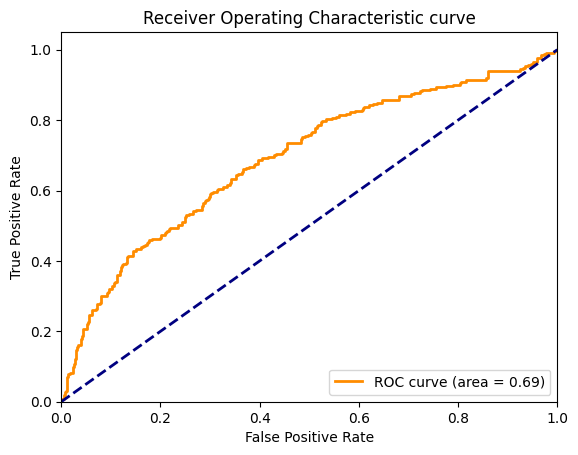

0.446071168211201
Optimal Threshold:  0.1585356444120407
Number of non-zero coefficients:  153


In [26]:

#measure the error of the model
from sklearn.metrics import mean_squared_error


#plot the AOC curve for the model as a function of threshold
from sklearn.metrics import roc_auc_score

y = train_df['matched']
y_pred = train_df['scores']
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)

#measure mae
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test, y_pred))



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.192e-02, tolerance: 1.824e-02
  model = cd_fast.enet_coordinate_descent(


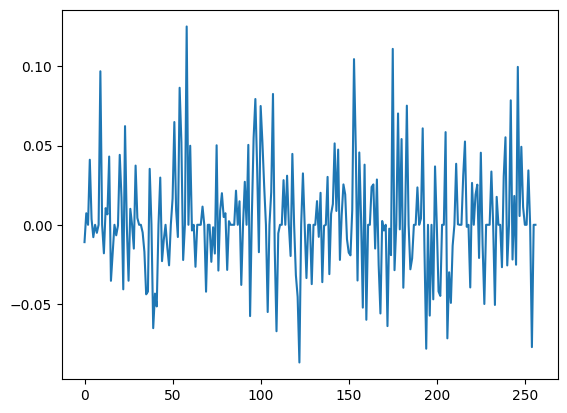

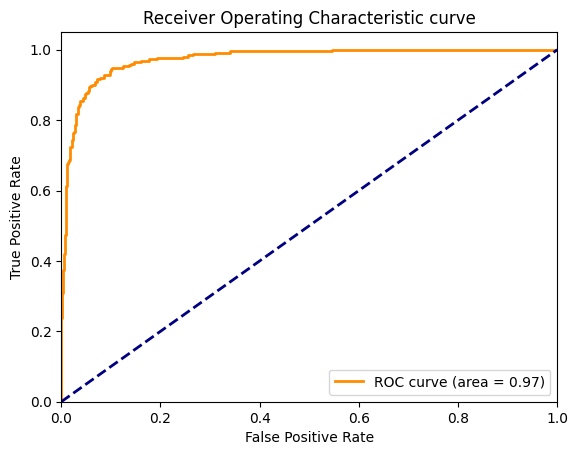

0.2739970279963036
Optimal Threshold:  0.3806593967659357
Number of non-zero coefficients:  187


In [27]:
# Run linear regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

#X = np.array(train_df['top_states'].tolist())
#X = np.array(train_df['last_hidden_state'].tolist())

X = np.array(train_df['last_hidden_state'].tolist())
#add an intercept
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = np.array(train_df['matched'])
scaler = StandardScaler()
X = scaler.fit_transform(X)
#set lasso model so that it can't predict less than 0
clf = Lasso(alpha=0.001)
clf.fit(X, y)
y_pred = clf.predict(X)
#y_pred[y_pred < 0] = 0
#find and report coefficients
coefficients = clf.coef_
plt.plot(coefficients)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)

#measure mae
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test, y_pred))



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))


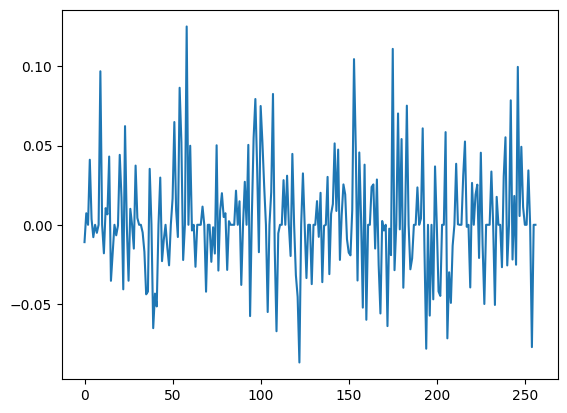

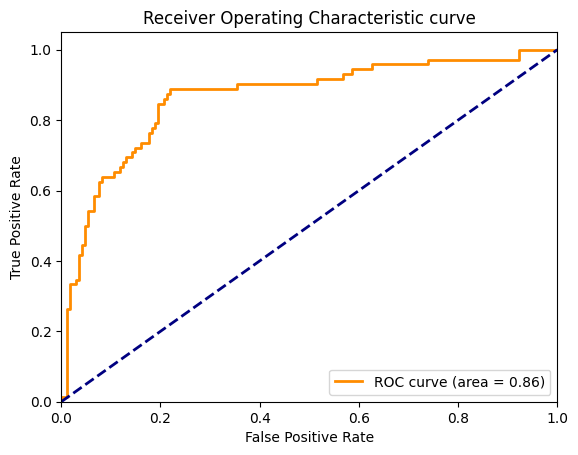

0.3831439120655797
Optimal Threshold:  0.3258390019468691
Number of non-zero coefficients:  187


In [33]:
# Run linear regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error



X = np.array(test_df['last_hidden_state'].tolist())
#add an intercept
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = np.array(test_df['matched'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_pred = clf.predict(X)

#find and report coefficients
coefficients = clf.coef_
plt.plot(coefficients)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)

#measure mae
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test, y_pred))



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))


In [29]:
y_pred

array([ 1.67117054e-01,  1.19153072e-01,  8.46116587e-01,  1.52113645e-01,
        5.52117388e-01,  2.91380626e-01,  2.18345178e-01,  2.51647206e-01,
        3.69382839e-01,  8.91597429e-01,  7.34951608e-01,  9.75817187e-01,
        1.15571069e-02,  4.48889564e-02,  3.80659397e-01,  7.11420326e-01,
        9.11547202e-01,  6.44038900e-01,  9.15591207e-01,  7.99038713e-01,
        1.35722746e-01,  8.38848356e-02,  2.21814087e-01,  1.95713352e-01,
       -2.27721979e-01,  1.74713130e-01, -6.62885574e-02, -7.33282823e-02,
        2.71849816e-01, -3.43263328e-02,  2.25755784e-02,  7.30404515e-01,
        7.72651622e-02,  5.82110267e-01,  3.15237623e-01, -2.64483355e-02,
        1.15828607e-01,  6.83145882e-01,  1.18415932e+00,  6.96162880e-01,
        1.05451874e+00,  1.02770864e-01,  7.38304490e-02, -1.37290848e-01,
        3.57536220e-03,  7.98993426e-01,  1.52877918e-01,  1.75059342e-01,
        3.64527597e-01,  2.02413433e-01,  3.27138510e-01, -5.48616050e-03,
        6.66666537e-01,  

In [30]:
#filter the GD Model results to reasonable boxes
def filter_model_bbox_outputs_rescore(results, outputs, image, params):
    params['area_threshold'] = 0.05

    width, height = image.size
    boxes = np.array(results[0]['boxes'].tolist())
    passing_area_idx = find_valid_boxes_by_area(boxes, width, height,params['area_threshold']
    )
    logits = outputs['logits'][0]
    probs = torch.sigmoid(logits)
    scores = np.array(torch.max(probs, dim=-1)[0].tolist())
    
    passing_score_idx = (scores > params['score_threshold']).astype(int)
    
    new_scores = []
    for cnt,lhs in enumerate(outputs.last_hidden_state.cpu().tolist()[0]):
        new_scores.append(np.sum(params['scalar'].transform(np.array(lhs + [1]).reshape(1,-1)) * params['coefficients']))
    
    new_passing_score_idx = (np.array(new_scores) > params['new_score_threshold']).astype(int)
    
    qualified_box_idx = find_indices(passing_area_idx & passing_score_idx & new_passing_score_idx, 1)
    
    skinny_filter = find_indices(remove_skinny_boxes(boxes[qualified_box_idx], threshold = params['skinny_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in skinny_filter]
    
    overlap_filter = find_indices(remove_overlapping_boxes(boxes[qualified_box_idx], scores[qualified_box_idx], threshold = params['overlap_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in overlap_filter]
    
    if params['display_image'] == True:
        labels = np.array(results[0]['labels'])
        category_bboxes = boxes[qualified_box_idx]
        cat_labels = ['AC Unit', 'AC leaking']
        category = ['AC Unit' for x in range(len(labels[qualified_box_idx]))]
        display_image_with_labels(image,category_bboxes, category)
    return qualified_box_idx

In [16]:
test_df2 = pd.DataFrame()
category_idx = 0
#for image_dict_idx in range(0, len(ds_dict['train'])): 
for image_dict_idx in range(0, len(ds_dict['test'])):

    human_labels = ds_dict['test'][image_dict_idx]['objects']
    image = ds_dict['test'][image_dict_idx]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    
        outputs = model(**inputs,output_hidden_states=True)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.0,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],
    
        )
    params = {}
    params['scalar'] = scaler
    params['coefficients'] = coefficients
    params['display_image'] = False
    params['area_threshold'] = 0.05
    params['score_threshold'] = 0.1
    params['new_score_threshold'] = 0.05
    params['overlap_threshold'] = 0.5
    params['skinny_threshold'] = 0.33
    qualified_box_idx = filter_model_bbox_outputs_rescore(results, outputs, image, params)
    
    filt_outputs = FilteredOutputs()
    
    for output_items in ['logits', 'pred_boxes', 'last_hidden_state']:
        # filter the tensor's 2nd dimension by qualified_box_idx
        setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
    
    
    results_round2 = processor.post_process_grounded_object_detection(
        filt_outputs,
        inputs.input_ids,
        box_threshold=0.0,
        text_threshold=0.00,
        target_sizes=[image.size[::-1]],
    
    )

    boxes = results_round2[0]['boxes']
    scores = results_round2[0]['scores'].tolist()
    new_scores = []
    for cnt,lhs in enumerate(filt_outputs.last_hidden_state.cpu().tolist()[0]):
        new_scores.append(np.sum(scaler.transform(np.array(lhs + [1]).reshape(1,-1)) * coefficients))
    mdf = pd.DataFrame(columns = ['model_boxes'])
    mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
    mdf['model_boxes'] = mdf['model_boxes']
    mdf['scores'] = scores
    mdf['new_scores'] = new_scores
    mdf['model_idx'] = mdf.index
    mdf['tmp_key'] = 1
    no_candidates = False
    if len(mdf) == 0:
        no_candidates = True
        mdf = pd.DataFrame({'model_boxes': [[0,0,0,0]], 'scores': [0], 'new_scores': [0], 'model_idx': [0], 'tmp_key': [1]})

    
    hdf = human_labels_to_df(human_labels, category_idx)
    hdf['human_idx'] = hdf.index
    hdf['tmp_key'] = 1
    annot_df = pd.merge(hdf,mdf, on='tmp_key')
    if no_candidates == False:
        annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
        best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
    
        best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
        logits = filt_outputs.logits.cpu().numpy()[0]
        logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
        best_match_df['logits'] = logits
    else:
        best_match_df = annot_df
        best_match_df['iou'] = np.nan
        best_match_df['model_idx'] = np.nan
        best_match_df['last_hidden_state'] = np.nan
        best_match_df['logits'] = np.nan
        
        
    test_df2 = pd.concat([test_df2,best_match_df], ignore_index=True)
    print(str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed')


KeyboardInterrupt



In [ ]:
test_df2.to_pickle('../data/models/ac_model/test_df2.pkl')

In [373]:
# load test_df2 from disk
test_df2 = pd.read_pickle('../data/models/ac_model/test_df2.pkl')


In [374]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


test_df2['iou'] = test_df2['iou'].fillna(0)

test_df2['matched'] = (test_df2['iou'] > 0).astype(int)
test_df2['predicted'] = (test_df2['new_scores'] > 0.1).astype(int)
y_test = np.array(test_df2['matched'].tolist())
y_pred = np.array(test_df2['predicted'].tolist()).reshape(-1,1)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7473684210526316
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        35
           1       0.75      0.90      0.82        60

    accuracy                           0.75        95
   macro avg       0.74      0.69      0.70        95
weighted avg       0.75      0.75      0.73        95

[[17 18]
 [ 6 54]]


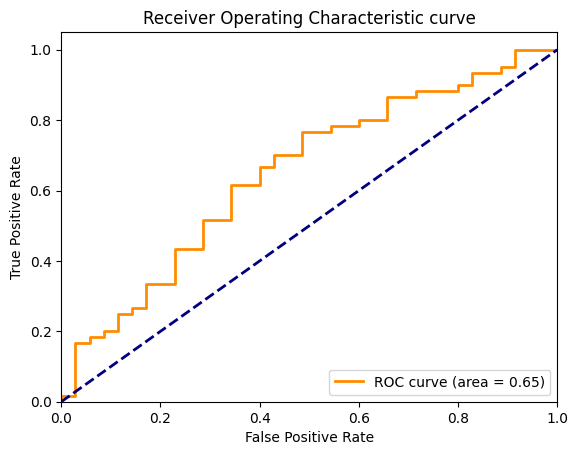

Optimal Threshold:  0.15024255216121674


In [379]:
y = test_df2['matched']
y_pred = test_df2['scores']
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2



plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()


# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]

print('Optimal Threshold: ', optimal_threshold)

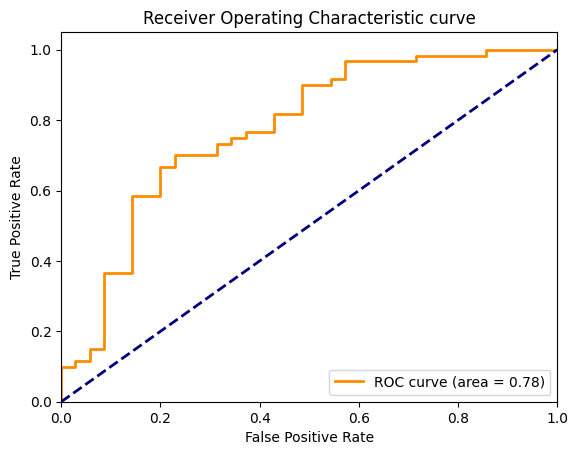

In [376]:
y = test_df2['matched']
y_pred = test_df2['new_scores']
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2



plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [354]:
test_df2

,annot_id,category,area,human_boxes,human_idx,tmp_key,model_boxes,scores,new_scores,model_idx,iou,last_hidden_state,logits,matched,predicted
0,217,0,1610,"[57, 69, 79, 92]",0,1,"[56, 67, 80, 94]",0.231921,0.487448,0.0,0.788571,"[-0.05715395510196686, -0.10921353101730347, -0.23560108244419098, -0.36804911494255066, -0.10899964720010757, 0.22735440731048584, 0.04868728667497635, 0.0584968701004982, 0.28069284558296204, -0.037344954907894135, -0.3260784149169922, 0.38047415018081665, 0.014420226216316223, -0.05241736024618149, 0.06341203302145004, -0.10664917528629303, -0.3599342107772827, 0.03260357677936554, -0.2657545506954193, 0.022429876029491425, -0.12035149335861206, 0.11174235492944717, 0.13286349177360535, 0.18808609247207642, -0.2159712314605713, -0.06882388144731522, -0.05292310565710068, -0.20606540143489838, -0.002350442111492157, -0.30520740151405334, -0.009150132536888123, 0.043087586760520935, 0.17256245017051697, 0.02554462105035782, -0.28868743777275085, -0.10002397745847702, -0.19029811024665833, -0.48751676082611084, -0.11344277858734131, -0.2876327633857727, -0.22231733798980713, -0.3299804925918579, 0.07768482714891434, 0.11874698102474213, -0.00946858525276184, -0.12019073963165283, -0.037912845611572266, -0.126487135887146, -0.3207019865512848, -0.3922276496887207, -0.0548861101269722, -0.15037567913532257, -0.41057994961738586, -0.11653237044811249, -0.3923470079898834, -0.0643845945596695, 0.18544147908687592, -0.34114140272140503, -0.5481634736061096, 0.20494288206100464, 0.1398821771144867, -0.2972184419631958, -0.20502969622612, -0.3624832034111023, 0.4085160791873932, -0.3258857727050781, 0.048521146178245544, 0.020913556218147278, 0.08648598194122314, -0.15582053363323212, -0.26091325283050537, -0.1351647824048996, 0.12943881750106812, -0.21311050653457642, -0.16769355535507202, -0.3539266288280487, -0.3827139735221863, 0.0173400416970253, 0.2865010201931, 0.0026990771293640137, -0.08231791853904724, -0.49435660243034363, -0.22911326587200165, 2.665419578552246, -0.5229977369308472, 0.18651746213436127, -0.18178728222846985, -0.14085358381271362, -0.25068241357803345, -0.008328475058078766, 0.3170923888683319, 0.05866926163434982, -0.15268389880657196, -0.13844676315784454, 0.0748348981142044, -0.09213712811470032, -0.12659387290477753, -0.02629151940345764, 0.08557415008544922, -0.24503956735134125, ...]","[-5.047874, -1.1974951, -1.298797, -1.2713541, -1.3057112, -4.2388506, -2.4032674, -2.3571055, -2.2023742, -3.037864, -1.7506242, -4.8293195, -5.238943, -5.16621, -5.4877853, -4.4298778, -3.6928515, -5.290555, -3.2582278, -1.8415267, -1.8295058, -1.9080074, -1.8537563, -1.7377644, -4.118514, -5.038136]",1,1
1,216,0,11926,"[95, 211, 123, 244]",1,1,"[84, 211, 126, 247]",0.199287,0.265817,0.0,0.619736,"[-0.136999249458313, -0.11686422675848007, -0.13964802026748657, -0.35494711995124817, -0.016169779002666473, 0.10786323994398117, 0.04785488545894623, -0.195937842130661, 0.13531187176704407, 0.007929868996143341, -0.29305583238601685, 0.45123377442359924, -0.051529332995414734, -0.03630613535642624, -0.10354568064212799, -0.21661123633384705, -0.31707799434661865, -0.05194418877363205, -0.15281382203102112, -0.06880148500204086, -0.15284395217895508, 0.1760445535182953, 0.1490161418914795, 0.01892852783203125, -0.23354601860046387, -0.016020596027374268, -0.006009489297866821, -0.19979143142700195, -0.17348766326904297, -0.22993087768554688, 0.03036601096391678, 0.08567468822002411, 0.1476917564868927, -0.025897469371557236, -0.3245031237602234, -0.18205691874027252, -0.27051621675491333, -0.48442885279655457, -0.12373995780944824, -0.21660785377025604, -0.13522428274154663, -0.08864302188158035, 0.03861293941736221, 0.03671461343765259, -0.1764291226863861, -0.13906365633010864, -0.06721936911344528, -0.1249367892742157, -0.17799368500709534, -0.20798221230506897, -0.10674242675304413, -0.10004843771457672, -0.3503645956516266, -0.14070667326450348, -0.28753724694252014, 0.16686247289180756, 0.163

In [290]:
len(filt_outputs.last_hidden_state.cpu().tolist()[0])

1

<Axes: >

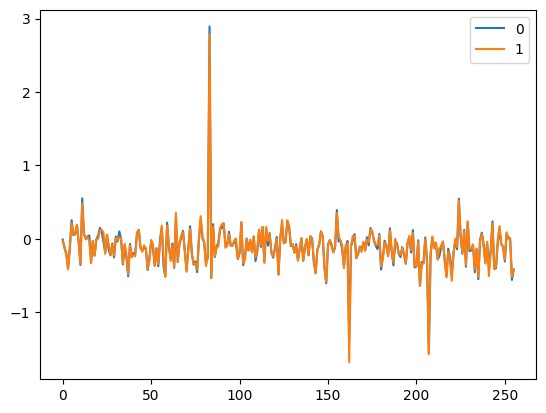

In [39]:
tmp = train_df.iloc[:].groupby(['matched'])['last_hidden_state'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0))
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T)
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T).plot(kind='line')

<Axes: >

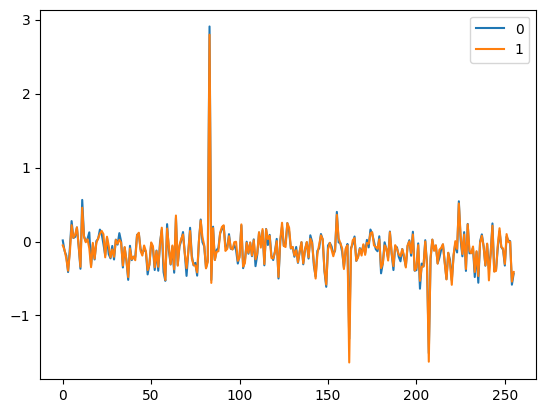

In [40]:
tmp = train_df.iloc[200:300].groupby(['matched'])['last_hidden_state'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0))
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T).plot(kind='line')

In [ ]:
# abs_top = np.abs(train_df.loc[:,'last_hidden_state'].mean(axis = 0))
# # get the index of the sorted absolut values
# abs_top_idx = np.argsort(abs_top)
# train_df['top_states'] = train_df['last_hidden_state'].apply(lambda x: x[abs_top_idx[0:250]])

In [207]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X = np.array(train_df['last_hidden_state'].tolist())
#X = np.array(train_df['scores']).reshape(-1,1)
y = np.array(train_df['matched'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.8461538461538461
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       130
           1       0.82      0.60      0.69        52

    accuracy                           0.85       182
   macro avg       0.83      0.77      0.79       182
weighted avg       0.84      0.85      0.84       182

[[123   7]
 [ 21  31]]


array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0])

In [252]:
# Run random forest regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X = np.array(train_df['last_hidden_state'].tolist())
y = np.array(train_df['iou'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#measure the error of the model


from sklearn.metrics import root_mean_squared_error
print(root_mean_squared_error(y_test, y_pred))








0.17185818229258376


In [254]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X = np.array(train_df['last_hidden_state'].tolist())
#X = train_df[['logits_score']]
#X = np.array(train_df['scores']).reshape(-1,1)
#X = np.concatenate([np.array(train_df['last_hidden_state'].tolist()),train_df['scores'].values.reshape(-1,1)],1)
y = np.array(train_df['matched'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8406593406593407
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       130
           1       0.85      0.54      0.66        52

    accuracy                           0.84       182
   macro avg       0.84      0.75      0.78       182
weighted avg       0.84      0.84      0.83       182

[[125   5]
 [ 24  28]]


In [197]:
y_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0])

/var/folders/2v/5ynl9w294pd7vyqtmlmp694r0000gn/T/ipykernel_81516/725016053.py:3: RuntimeWarning: Mean of empty slice.
  matched_scaled = X_train[y_train == 1].mean(axis=0)
/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


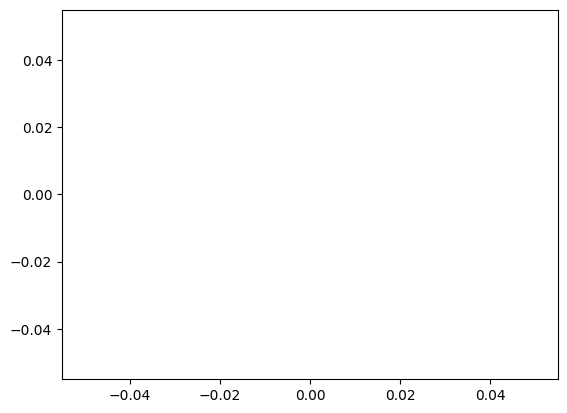

In [69]:
import matplotlib.pyplot as plt
#find the mean of X_train where y = 1
matched_scaled = X_train[y_train == 1].mean(axis=0)
non_matched_scaled = X_train[y_train == 0].mean(axis=0)

plt.figure()

plt.plot(matched_scaled)
#plt.plot(non_matched_scaled)

In [ ]:
plt.imshow(non_matched_scaled.reshape(16,16))

In [ ]:
X

In [331]:
train_df.iou.mean()


0.1198163055785481

In [260]:
train_df['prediction']

0      0.005462
1     -0.094943
2      0.182579
3     -0.011011
4      0.175999
         ...   
902    0.100653
903    0.148996
904    0.012451
905    0.091748
906    0.209457
Name: prediction, Length: 907, dtype: float64

In [233]:
clf

Lasso(alpha=0.001)

In [268]:
train_df['logits_score'] = train_df['logits'].apply(lambda x: np.sum(x))

In [323]:
train_df[['iou', 'scores','prediction','logits_score']].corr()

,iou,scores,prediction,logits_score
iou,1.000000,0.373012,0.754698,0.288580
scores,0.373012,1.000000,0.498894,0.723928
prediction,0.754698,0.498894,1.000000,0.389679
logits_score,0.288580,0.723928,0.389679,1.000000


In [329]:
test_df2[['iou', 'new_scores','scores']].corr()

,iou,new_scores,scores
iou,1.000000,0.381952,0.128269
new_scores,0.381952,1.000000,0.379937
scores,0.128269,0.379937,1.000000


In [ ]:
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).plot()
print(pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).corr())

In [ ]:
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).plot()
print(pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).corr())

In [ ]:

for output_items in outputs.keys():
    #if output_items is not a tuple, print the shape
    if not isinstance(outputs[output_items], tuple):
        print(output_items + ' ' + str(outputs[output_items].shape))
    else:
        print(str(outputs[output_items][0].shape) + ' ' + str(outputs[output_items][1].shape))


In [ ]:
from transformers.image_transforms import center_to_corners_format
def convert_box_format(tensor_norm_boxes,img_w, img_h):
    boxes = center_to_corners_format(tensor_norm_boxes)
    return boxes

In [ ]:

human_labels

In [ ]:
human_labels_to_df(human_labels, 0)

In [ ]:
boxes.tolist()

In [ ]:
mdf

In [ ]:
annot_df

In [ ]:
filt_outputs.logits.cpu()

In [ ]:
Polygon(list(category_bboxes[0].astype(int)))

In [ ]:
list(category_bboxes[0])

In [ ]:
outputs.keys()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(decoder[0])


In [ ]:
outputs['pred_boxes'].shape

In [ ]:
# find the area of each box in the image from the results and compare to the size of the image. If the box is too large, it is likely a false positive. Threshold for the area can be set. filter all fields in results[0] if the threshold is not met.

def filter_by_boxes(results, image):
    width, height = image.size
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for i in range(len(results[0]['boxes'])):
        box = results[0]['boxes'][i]
        area = (box[2] - box[0]) * (box[3] - box[1])
        if area < width * height * 0.05:
            filtered_boxes.append(box)
            filtered_scores.append(float(results[0]['scores'][i]))
            filtered_labels.append(str(results[0]['labels'][i]))
    if len(filtered_boxes) > 0:
        filtered_results = [{'boxes': torch.stack(filtered_boxes), 'scores': torch.tensor(filtered_scores), 'labels': filtered_labels}]
    else:
        filtered_results = [{'boxes': torch.tensor([]), 'scores': torch.tensor([]), 'labels': []}]
    return filtered_results


In [ ]:

#image = ds[22]['image']

#text = "a small HVAC machine on a roof of a building, which usually appears as a white or gray box with one or a few darker, circular fans on top that look like dots." #(word 'machine' helps on ds[13]['image']"" )

#text = "a small HVAC (air conditioner) unit on a roof, white or gray box with a dark, circular fan dot." #("winner on  ds[3]['image']")

#text = "a tiny HVAC (air conditioner) unit that MUST be ON a roof." #(winner on ds[8]['image'], overconfident on ds[10]['image'])

text = "a tiny HVAC (air conditioner) machine that MUST be ON a roof." #(word 'machine' helps on ds[16]['image'])
#text = "robot eyes"

result_set = [None] * len(ds)
for cnt in range(0, 150):
    image = ds[cnt]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)

        outputs = model(**inputs)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.3,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],

        )
        #results = filter_by_boxes(results, image)
        result_set[cnt] = results
        for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            print(
                f"Detected  '" + label + "' with confidence "
                f"{round(score.item(), 3)} at location {box}"
            )
        print(str(cnt) + ' ' + 'processed')

In [ ]:
#save the results to a file
# import pickle
# with open('../data/models/ac_model/ac_detect_a_tiny_hvac_thresh_p3' + '.pkl', 'wb') as f:
#     pickle.dump(result_set, f)

In [ ]:
last_hidden_states = outputs.last_hidden_state_vision

In [ ]:
last_hidden_states.shape

GroundingDinoModel

class transformers.GroundingDinoModel
<
source
>
( config: GroundingDinoConfig )

Parameters

config (GroundingDinoConfig) — Model configuration class with all the parameters of the model. Initializing with a config file does not load the weights associated with the model, only the configuration. Check out the from_pretrained() method to load the model weights.
The bare Grounding DINO Model (consisting of a backbone and encoder-decoder Transformer) outputting raw hidden-states without any specific head on top.

This model inherits from PreTrainedModel. Check the superclass documentation for the generic methods the library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads etc.)

This model is also a PyTorch torch.nn.Module subclass. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and behavior.

forward
<
source
>
( pixel_values: Tensorinput_ids: Tensortoken_type_ids: Optional = Noneattention_mask: Optional = Nonepixel_mask: Optional = Noneencoder_outputs = Noneoutput_attentions = Noneoutput_hidden_states = Nonereturn_dict = None ) → transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or tuple(torch.FloatTensor)

Parameters

pixel_values (torch.FloatTensor of shape (batch_size, num_channels, height, width)) — Pixel values. Padding will be ignored by default should you provide it.
Pixel values can be obtained using AutoImageProcessor. See GroundingDinoImageProcessor.call() for details.

input_ids (torch.LongTensor of shape (batch_size, text_sequence_length)) — Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide it.
Indices can be obtained using AutoTokenizer. See GroundingDinoTokenizer.__call__ for details.

token_type_ids (torch.LongTensor of shape (batch_size, text_sequence_length), optional) — Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token
What are token type IDs?

attention_mask (torch.LongTensor of shape (batch_size, text_sequence_length), optional) — Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
1 for tokens that are real (i.e. not masked),
0 for tokens that are padding (i.e. masked).
What are attention masks?

pixel_mask (torch.LongTensor of shape (batch_size, height, width), optional) — Mask to avoid performing attention on padding pixel values. Mask values selected in [0, 1]:
1 for pixels that are real (i.e. not masked),
0 for pixels that are padding (i.e. masked).
What are attention masks?

encoder_outputs (tuple(tuple(torch.FloatTensor), optional) — Tuple consists of (last_hidden_state_vision, optional: last_hidden_state_text, optional: vision_hidden_states, optional: text_hidden_states, optional: attentions) last_hidden_state_vision of shape (batch_size, sequence_length, hidden_size), optional) is a sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.

output_attentions (bool, optional) — Whether or not to return the attentions tensors of all attention layers. See attentions under returned tensors for more detail.

output_hidden_states (bool, optional) — Whether or not to return the hidden states of all layers. See hidden_states under returned tensors for more detail.

return_dict (bool, optional) — Whether or not to return a ModelOutput instead of a plain tuple.
Returns

transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or tuple(torch.FloatTensor)

A transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or a tuple of torch.FloatTensor (if return_dict=False is passed or when config.return_dict=False) comprising various elements depending on the configuration (GroundingDinoConfig) and inputs.

last_hidden_state (torch.FloatTensor of shape (batch_size, num_queries, hidden_size)) — Sequence of hidden-states at the output of the last layer of the decoder of the model.
init_reference_points (torch.FloatTensor of shape (batch_size, num_queries, 4)) — Initial reference points sent through the Transformer decoder.
intermediate_hidden_states (torch.FloatTensor of shape (batch_size, config.decoder_layers, num_queries, hidden_size)) — Stacked intermediate hidden states (output of each layer of the decoder).
intermediate_reference_points (torch.FloatTensor of shape (batch_size, config.decoder_layers, num_queries, 4)) — Stacked intermediate reference points (reference points of each layer of the decoder).
decoder_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, num_queries, hidden_size). Hidden-states of the decoder at the output of each layer plus the initial embedding outputs.
decoder_attentions (tuple(tuple(torch.FloatTensor)), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of tuples of torch.FloatTensor (one for attention for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length). Attentions weights after the attention softmax, used to compute the weighted average in the self-attention, cross-attention and multi-scale deformable attention heads.
encoder_last_hidden_state_vision (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size), optional) — Sequence of hidden-states at the output of the last layer of the encoder of the model.
encoder_last_hidden_state_text (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size), optional) — Sequence of hidden-states at the output of the last layer of the encoder of the model.
encoder_vision_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the vision embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size). Hidden-states of the vision encoder at the output of each layer plus the initial embedding outputs.
encoder_text_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the text embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size). Hidden-states of the text encoder at the output of each layer plus the initial embedding outputs.
encoder_attentions (tuple(tuple(torch.FloatTensor)), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of tuples of torch.FloatTensor (one for attention for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length). Attentions weights after the attention softmax, used to compute the weighted average in the text-vision attention, vision-text attention, text-enhancer (self-attention) and multi-scale deformable attention heads. attention softmax, used to compute the weighted average in the bi-attention heads.
enc_outputs_class (torch.FloatTensor of shape (batch_size, sequence_length, config.num_labels), optional, returned when config.two_stage=True) — Predicted bounding boxes scores where the top config.num_queries scoring bounding boxes are picked as region proposals in the first stage. Output of bounding box binary classification (i.e. foreground and background).
enc_outputs_coord_logits (torch.FloatTensor of shape (batch_size, sequence_length, 4), optional, returned when config.two_stage=True) — Logits of predicted bounding boxes coordinates in the first stage.
The GroundingDinoModel forward method, overrides the __call__ special method.

Although the recipe for forward pass needs to be defined within this function, one should call the Module instance afterwards instead of this since the former takes care of running the pre and post processing steps while the latter silently ignores them.

Examples:

Copied
from transformers import AutoProcessor, AutoModel
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "a cat."

processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = AutoModel.from_pretrained("IDEA-Research/grounding-dino-tiny")

inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)
[1, 900, 256]

In [ ]:
# plt.imshow()
outputs.keys()
logits = outputs['logits'][0].detach().cpu()
#squeeze out -inf columns from logits tensor
logits = logits[:, (logits != float('-inf')).any(dim=0)]
decoder = outputs['decoder_hidden_states'][0].detach().cpu()
#decoder = decoder[:, (decoder != float('-inf')).any(dim=0)]

In [ ]:
#get the last hidden layer from the visual component of the HuggingFace GroundingDino model



In [ ]:
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

for cnt in range(0, 150):
    if len(result_set[cnt][0]['scores']) > 0:
        results = filter_by_boxes(result_set[cnt], image)
        if len(results[0]['scores']) > 0:
            for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
                box = [round(i, 2) for i in box.tolist()]
                print(
                    f"Detected  '" + label + "' with confidence "
                    f"{round(score.item(), 3)} at location {box}"
                )


    show_example = True
    if show_example == True:
        tensor_boxes = results[0]["boxes"]
        image = ds[cnt]['image']
        tensor_image = transforms.ToTensor()(image)
        # Convert the Tensor back to uint8
        tensor_image = tensor_image.mul(255).byte()
    if len(results[0]['scores']) > 0:
        bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
        bbox_img = torchvision.transforms.ToPILImage()(bbox_img)

        bbox_img.show()

In [ ]:

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.25,
    text_threshold=0.00,
    target_sizes=[image.size[::-1]],

)
results = filter_by_boxes(results, image)

for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected  '" + label + "' with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )




import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

show_example = True
if show_example == True:
    tensor_boxes = results[0]["boxes"]

    tensor_image = transforms.ToTensor()(image)
    # Convert the Tensor back to uint8
    tensor_image = tensor_image.mul(255).byte()

    bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
    bbox_img = torchvision.transforms.ToPILImage()(bbox_img)

    bbox_img.show()

In [ ]:
results


In [ ]:
results

In [ ]:
filtered_boxes

In [ ]:
results[0]['labels']

In [ ]:


import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

show_example = True
if show_example == True:
    tensor_boxes = torch.tensor(results[0]["boxes"]) 
    
    tensor_image = transforms.ToTensor()(image)
    # Convert the Tensor back to uint8
    tensor_image = tensor_image.mul(255).byte()
    
    bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
    bbox_img = torchvision.transforms.ToPILImage()(bbox_img)
    
    bbox_img.show()

In [ ]:
pd.DataFrame(hf_ds).iloc[2]['image']

In [ ]:
import datasets
dir(PIL.Image)

In [ ]:
hf_ds[1]['image']

In [ ]:
#convert hf_ds json list to a pyarrow dataset
import pyarrow as pa
import pyarrow.dataset as ds
def gen(hf_ds):
    for i in hf_ds:
        yield i

ds = Dataset.from_generator(gen(hf_ds))





In [ ]:
([int(mask_df[mask_df['image_id'] == row]['x']), 
 int(mask_df[mask_df['image_id'] == row]['y']), 
 int(mask_df[mask_df['image_id'] == row]['w']), 
 int(mask_df[mask_df['image_id'] == row]['h']])

In [ ]:
# Convert my full_training set into a HuggingFace dataset for object detection in a format that works with groundingdino

from PIL import Image

def convert_to_hf_dataset(bbox_df):
    from datasets import Dataset
    from PIL import Image
    data

    
{
  'image_id': 366,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
  'width': 500,
  'height': 500,
  'objects': {
    'id': [1932, 1933, 1934],
    'area': [27063, 34200, 32431],
    'bbox': [[29.0, 11.0, 97.0, 279.0],
      [201.0, 1.0, 120.0, 285.0],
      [382.0, 0.0, 113.0, 287.0]],
    'category': [0, 0, 0]
  }
}

In [ ]:
from datasets import Dataset
from PIL import Image

hf_ds = Dataset.from_pandas(full_train)

In [ ]:
np.array(mask_geometry[0].exterior)

In [ ]:
#May be greater than 100 you have intersecting sets, need to resolve with filter
agree_bin = matched_sets.groupby(['name','percent_agreement']).size().rename('count').reset_index().join(matched_sets.groupby(['name']).size().rename('total'), on = 'name')
agree_bin['percent_total'] = agree_bin['count']/agree_bin['total']*100
print(agree_bin)


In [ ]:
#matched_sets.copy(deep = True)

In [ ]:
len(label_set)

In [ ]:
filt_connected_sets = matched_sets[matched_sets['num_agree_in_set'] >= 3]


In [ ]:
min_matches_per_image = 3

worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

#labeler_df = connected_sets.copy(deep = True)
labeler_df = matched_sets[matched_sets['num_agree_in_set'] >= min_matches_per_image]
labeler_df = labeler_df[['image_id','name']].drop_duplicates()
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'})
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'})
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

worker_comp_to_prime = pd.merge(comp_to_prime, worker_has_polygon[['worker','cross_join']].drop_duplicates(), on = ['cross_join'], how = 'outer').fillna(0)
comp_to_prime = comp_to_prime.drop(columns = ['cross_join']).fillna(0)
worker_comp_to_prime = worker_comp_to_prime.drop(columns = ['cross_join'])
worker_has_polygon = worker_has_polygon.drop(columns = ['cross_join'])

worker_comp_to_prime = pd.merge(worker_comp_to_prime, worker_has_polygon, on = ['image_id','name','worker'], how = 'outer').fillna(0)

In [ ]:
comp_to_prime[comp_to_prime['match'] != 1]

In [ ]:
# print('Percentage: ')
# print(comp_to_prime.groupby(['name']).mean(['match','hit','correct_rejection','false_alarm','miss']))

# print('Sum: ')
# print(comp_to_prime.groupby(['name']).sum(['match','hit','correct_rejection','false_alarm','miss']))

In [ ]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC Unit'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

In [ ]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

In [ ]:
worker_comp_to_prime['worker'].unique()

In [ ]:
'labeler_consensus'

In [ ]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC Unit') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC leaking') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:


print(confusion_matrix)

In [ ]:
def calculate_f1_score(confusion_matrix):
    # Calculate precision and recall from the confusion matrix
    TruePositives = confusion_matrix[1][1]
    FalsePositives = confusion_matrix[0][1]
    FalseNegatives = confusion_matrix[1][0]

    precision = TruePositives / (TruePositives + FalsePositives)
    recall = TruePositives / (TruePositives + FalseNegatives)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC Unit'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)
f1_score_leaking = calculate_f1_score(confusion_matrix)
print(confusion_matrix)
print('AC Unit: ' + str(f1_score_leaking))

# Assuming 'confusion_matrix' is the confusion matrix you have calculated
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)
f1_score_leaking = calculate_f1_score(confusion_matrix)
print(confusion_matrix)
print('AC leaking: ' + str(f1_score_leaking))



In [ ]:
labels


In [ ]:
worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

labeler_df = matched_sets.copy(deep = True)
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'}).fillna(0)
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'}).fillna(0)
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

In [ ]:
for agreement in comp_to_prime['percent_agreement'].unique(): 
    comp_filt = ((comp_to_prime['name'] == 'AC Unit') & (comp_to_prime['percent_agreement'] == agreement))
    confusion_matrix = pd.crosstab(comp_to_prime.loc[comp_filt,'prime_label'], comp_to_prime.loc[(comp_to_prime['percent_agreement'] == agreement),'labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(str(agreement) + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:


accuracy_by_agreement = comp_to_prime.groupby(['name','percent_agreement'])['match'].mean().rename('percent_accuracy')*100

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'accuracy_by_agreement' is your DataFrame
accuracy_by_agreement = accuracy_by_agreement.reset_index()

# Create a pivot table
pivot_table = accuracy_by_agreement.pivot(index='percent_agreement', columns='name', values='percent_accuracy')

# Plot the data
pivot_table.plot(kind='bar', stacked=False)

# Add labels and title
plt.xlabel('% Labelers Match on Object Detection')
plt.ylabel('% Accuracy')
plt.title('Accuracy by % Labelers Match on Object Detection')
legend = plt.legend(title='Object Type', loc='lower left')
# Show the plot
plt.show()

In [ ]:
accuracy_by_agreement

In [ ]:
matched_sets

In [ ]:
# Path: image_classification.ipynb


def set_seed(seed):
    # Set the random seed for reproducibility
    import torch
    import numpy as np
    import random
    torch.backends.cudnn.deterministic = True

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string


In [ ]:
mask_df
            #print(f'Image {image_id} cropped and saved to {cropped_image_path}')

In [ ]:
len(image_df[image_df['w'] == 0])

In [ ]:
len(matched_sets)